In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [6]:
!pip install -q tensorflow-datasets

You should consider upgrading via the '/home/jh/.virtualenvs/dl4cv/bin/python -m pip install --upgrade pip' command.


In [7]:
import tensorflow_datasets as tfds

In [8]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /home/jh/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6KQNNI/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/jh/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6KQNNI/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/jh/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6KQNNI/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/jh/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [9]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

In [10]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s, l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

In [11]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [12]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? b'this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received '
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 5s 205us/sample - loss: 0.4971 - accuracy: 0.7387 - val_loss: 0.3536 - val_accuracy: 0.8446
Epoch 2/10
25000/25000 [==============================] - 6s 225us/sample - loss: 0.2447 - accuracy: 0.9040 - val_loss: 0.3665 - val_accuracy: 0.8400
Epoch 3/10
25000/25000 [==============================] - 5s 208us/sample - loss: 0.1032 - accuracy: 0.9720 - val_loss: 0.4458 - val_accuracy: 0.8263
Epoch 4/10
25000/25000 [==============================] - 6s 232us/sample - loss: 0.0271 - accuracy: 0.9964 - val_loss: 0.5321 - val_accuracy: 0.8250
Epoch 5/10
25000/25000 [==============================] - 6s 249us/sample - loss: 0.0073 - accuracy: 0.9993 - val_loss: 0.5968 - val_accuracy: 0.8224
Epoch 6/10
25000/25000 [==============================] - 5s 207us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.6466 - val_accuracy: 0.8284
Epoch 7/10
25000/25000 [==========================

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [17]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [18]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

In [19]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 68, 105, 12, 7, 491, 1216]]


In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 5s 206us/sample - loss: 0.5700 - accuracy: 0.7458 - val_loss: 0.4097 - val_accuracy: 0.8356
Epoch 2/10
25000/25000 [==============================] - 5s 210us/sample - loss: 0.3494 - accuracy: 0.8565 - val_loss: 0.3379 - val_accuracy: 0.8560
Epoch 3/10
25000/25000 [==============================] - 5s 220us/sample - loss: 0.2817 - accuracy: 0.8859 - val_loss: 0.3299 - val_accuracy: 0.8570
Epoch 4/10
25000/25000 [==============================] - 7s 262us/sample - loss: 0.2451 - accuracy: 0.9036 - val_loss: 0.3391 - val_accuracy: 0.8549
Epoch 5/10
25000/25000 [==============================] - 5s 209us/sample - loss: 0.2183 - accuracy: 0.9174 - val_loss: 0.3550 - val_accuracy: 0.8504
Epoch 6/10
25000/25000 [==============================] - 5s 215us/sample - loss: 0.1972 - accuracy: 0.9274 - val_loss: 0.3738 - val_accuracy: 0.8483
Epoch 7/10
25000/25000 [==========================

In [22]:
reverse_word_index = dict([(value, key) for(key,value) in word_index.items()])

In [31]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']
tokenizer = info.features['text'].encoder
print(tokenizer.subwords)

Shuffling and writing examples to /home/jh/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAEMN2A/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/jh/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAEMN2A/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/jh/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAEMN2A/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/jh/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don',

In [32]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [34]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [35]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [36]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.6850 - accuracy: 0.5729 - val_loss: 0.6598 - val_accuracy: 0.6510
Epoch 2/10
391/391 [==============================] - 7s 18ms/step - loss: 0.5702 - accuracy: 0.7751 - val_loss: 0.4882 - val_accuracy: 0.8277
Epoch 3/10
391/391 [==============================] - 7s 17ms/step - loss: 0.4050 - accuracy: 0.8606 - val_loss: 0.3837 - val_accuracy: 0.8545
Epoch 4/10
391/391 [==============================] - 6s 16ms/step - loss: 0.3204 - accuracy: 0.8870 - val_loss: 0.3401 - val_accuracy: 0.8707
Epoch 5/10
391/391 [==============================] - 7s 17ms/step - loss: 0.2782 - accuracy: 0.9002 - val_loss: 0.3262 - val_accuracy: 0.8678
Epoch 6/10
391/391 [==============================] - 7s 17ms/step - loss: 0.2508 - accuracy: 0.9094 - val_loss: 0.3139 - val_accuracy: 0.8784
Epoch 7/10
391/391 [==============================] - 7s 18ms/step - loss: 0.2272 - accuracy: 0.9180 - val_loss: 0.3058 - val_accuracy: 0.8804

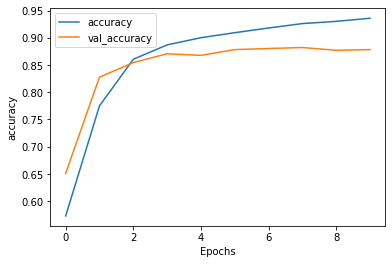

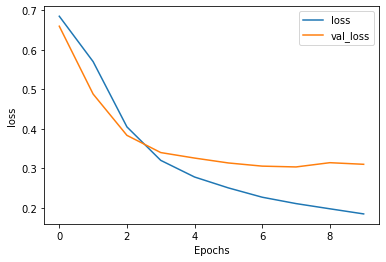

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [39]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

(8185, 64)
